## ------------------------------------- Классификатор эмоций --------------------------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

# Путь к ZIP-файлу
zip_file_path = '/content/drive/MyDrive/april_development/emotions.zip'

# Папка, в которую нужно распаковать файлы
extract_folder = '/content/drive/MyDrive/april_development/emotions'

# Открытие ZIP-файла
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Распаковка файлов в указанную папку
    zip_ref.extractall(extract_folder)

print('Распаковка завершена.')


Распаковка завершена.


In [ ]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt


train_dir='/content/drive/MyDrive/april_development/emotions/train/'
test_dir='/content/drive/MyDrive/april_development/emotions/test/'

In [ ]:
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<Axes: >

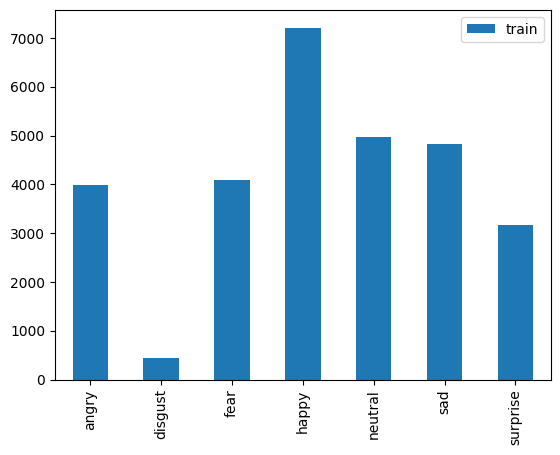

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

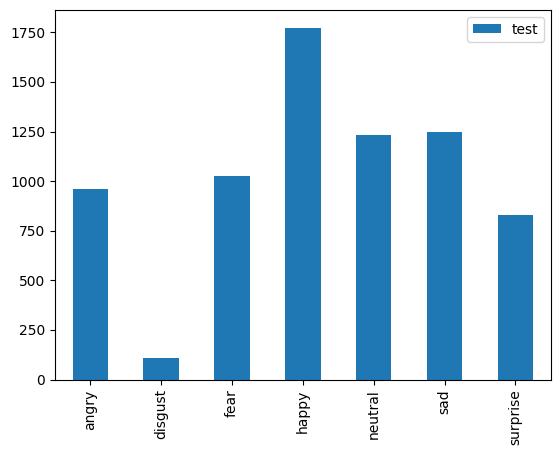

In [ ]:
test_count.transpose().plot(kind='bar')

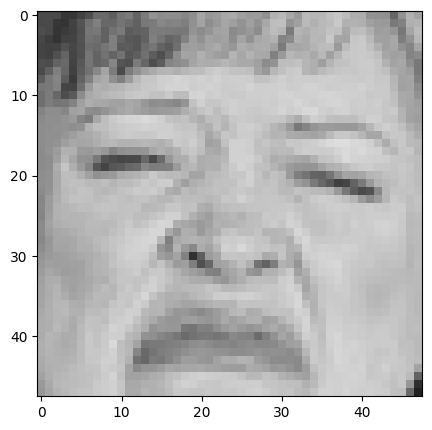

In [ ]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread('/content/drive/MyDrive/april_development/emotions/train/disgust/Training_11050021.jpg')
img = cv2.cvtColor(img,  cv2.COLOR_RGB2BGR)

plt.figure(figsize=(5,5))
plt.imshow(img)


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.images = []
        self.labels = []

        for class_name in self.class_names:
            class_dir = os.path.join(self.root_dir, class_name)
            for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                self.images.append(image_path)
                self.labels.append(self.class_names.index(class_name))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
from torchvision import transforms

# Определение преобразований для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создание экземпляра класса Dataset
train_dataset = EmotionDataset('/content/drive/MyDrive/april_development/emotions/train', transform=transform)

# Создание итератора для обучения
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


# Создание экземпляра класса Dataset для тестового набора данных
test_dataset = EmotionDataset('/content/drive/MyDrive/april_development/emotions/test', transform=transform)

# Создание итератора для тестового набора данных
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

datasetsizes = {'train': len(train_dataset), 'test': len(test_dataset)}


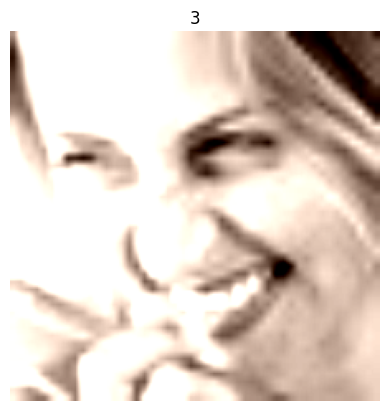

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Получение одного изображения из DataLoader
for batch in train_loader:
    inputs, labels = batch
    image = inputs[0]
    label = labels[0]

    image_array = np.transpose(image.numpy(), (1, 2, 0))
    image_array = (image_array * 0.5) + 0.5  # Нормализация данных изображения (приводим значения в диапазон [0, 1])

    image_bgr = cv2.cvtColor(image_array.astype(np.float32), cv2.COLOR_RGB2BGR)

    plt.imshow(image_bgr)
    plt.axis('off')  # Отключение осей
    plt.title(label.item())  # Отображение метки класса
    plt.show()

    break


In [ ]:
len(train_dataset), len(train_loader), len(train_dataset)/8 # хорошо, если делится нацело

(28709, 898, 3588.625)

In [ ]:
from tqdm import tqdm
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], "test": []}

    pbar = tqdm(total=num_epochs, desc="Training Progress")

    for epoch in range(num_epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Устанавливаем режим обучения для модели
            else:
                model.eval()  # Устанавливаем режим оценки для модели

            running_loss = 0.0
            running_corrects = 0

            pbar.set_postfix({'Phase': phase})
            pbar.refresh()

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasetsizes[phase]
            epoch_acc = running_corrects.double() / datasetsizes[phase]

            losses[phase].append(epoch_loss)

            pbar.set_postfix({'Epoch Loss': epoch_loss, 'Epoch Acc': epoch_acc})
            pbar.update(1)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    pbar.close()

    time_elapsed = time.time() - since
    print('Обучение завершено за {:.0f}м {:.0f}с'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Лучшая точность на валидации: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, losses


In [ ]:
import torch
import torchvision.models as models

model = models.resnet34(pretrained=True)

# Размораживаем последние несколько слоев модели для fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True

# Заменяем последний полносвязный слой на новый с нужным количеством классов
model.fc = torch.nn.Linear(model.fc.in_features, 7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [ ]:
model, losses = train_model(model, loss, optimizer, scheduler, num_epochs=30);




Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]


Training Progress:   0%|          | 0/30 [00:00<?, ?it/s, Phase=train]


Training Progress:   0%|          | 0/30 [00:00<?, ?it/s, Phase=train]


Training Progress:   0%|          | 0/30 [03:42<?, ?it/s, Epoch Loss=1.34, Epoch Acc=tensor(0.4924, device='cuda:0', dtype=torch.float64)]


Training Progress:   3%|▎         | 1/30 [03:42<1:47:29, 222.39s/it, Epoch Loss=1.34, Epoch Acc=tensor(0.4924, device='cuda:0', dtype=torch.float64)]


Training Progress:   3%|▎         | 1/30 [03:42<1:47:29, 222.39s/it, Phase=test]                                                                     


Training Progress:   3%|▎         | 1/30 [03:42<1:47:29, 222.39s/it, Phase=test]


Training Progress:   3%|▎         | 1/30 [04:13<1:47:29, 222.39s/it, Epoch Loss=1.24, Epoch Acc=tensor(0.5332, device='cuda:0', dtype=torch.float64)]


Training Progress:   7%|▋         | 2/30 [04:13<51:17, 109.90s/it, Epoch Loss=1.24, Epoch Acc=tensor(0.5332, de

KeyboardInterrupt: ignored

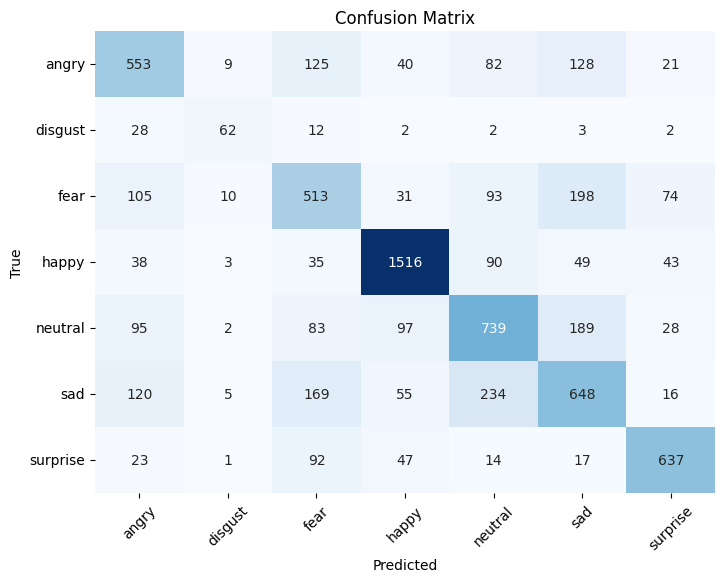

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(confusion_matrix, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def build_confusion_matrix(model, dataloader, device):
    num_classes = len(dataloader.dataset.class_names)
    confusion_matrix = np.zeros((num_classes, num_classes))

    model.eval()  # Устанавливаем режим оценки для модели

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False, desc="Building confusion matrix"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

# Получение матрицы ошибок
confusion_matrix = build_confusion_matrix(model, test_loader, 'cuda')
class_names = test_loader.dataset.class_names  # Список имен классов

# Построение и отображение матрицы ошибок
plot_confusion_matrix(confusion_matrix, class_names)


In [ ]:
import shutil

torch.save(model.state_dict(), 'emotional_classificator.pt')
shutil.move('emotional_classificator.pt', '/content/drive/MyDrive/april_development/emotional_classificator.pt')

'/content/drive/MyDrive/april_development/emotional_classificator.pt'